In [4]:
# MCP server exposes -- promt , resources and tools

In [2]:
import arxiv
import json
import os
from typing import List
from dotenv import load_dotenv
import anthropic

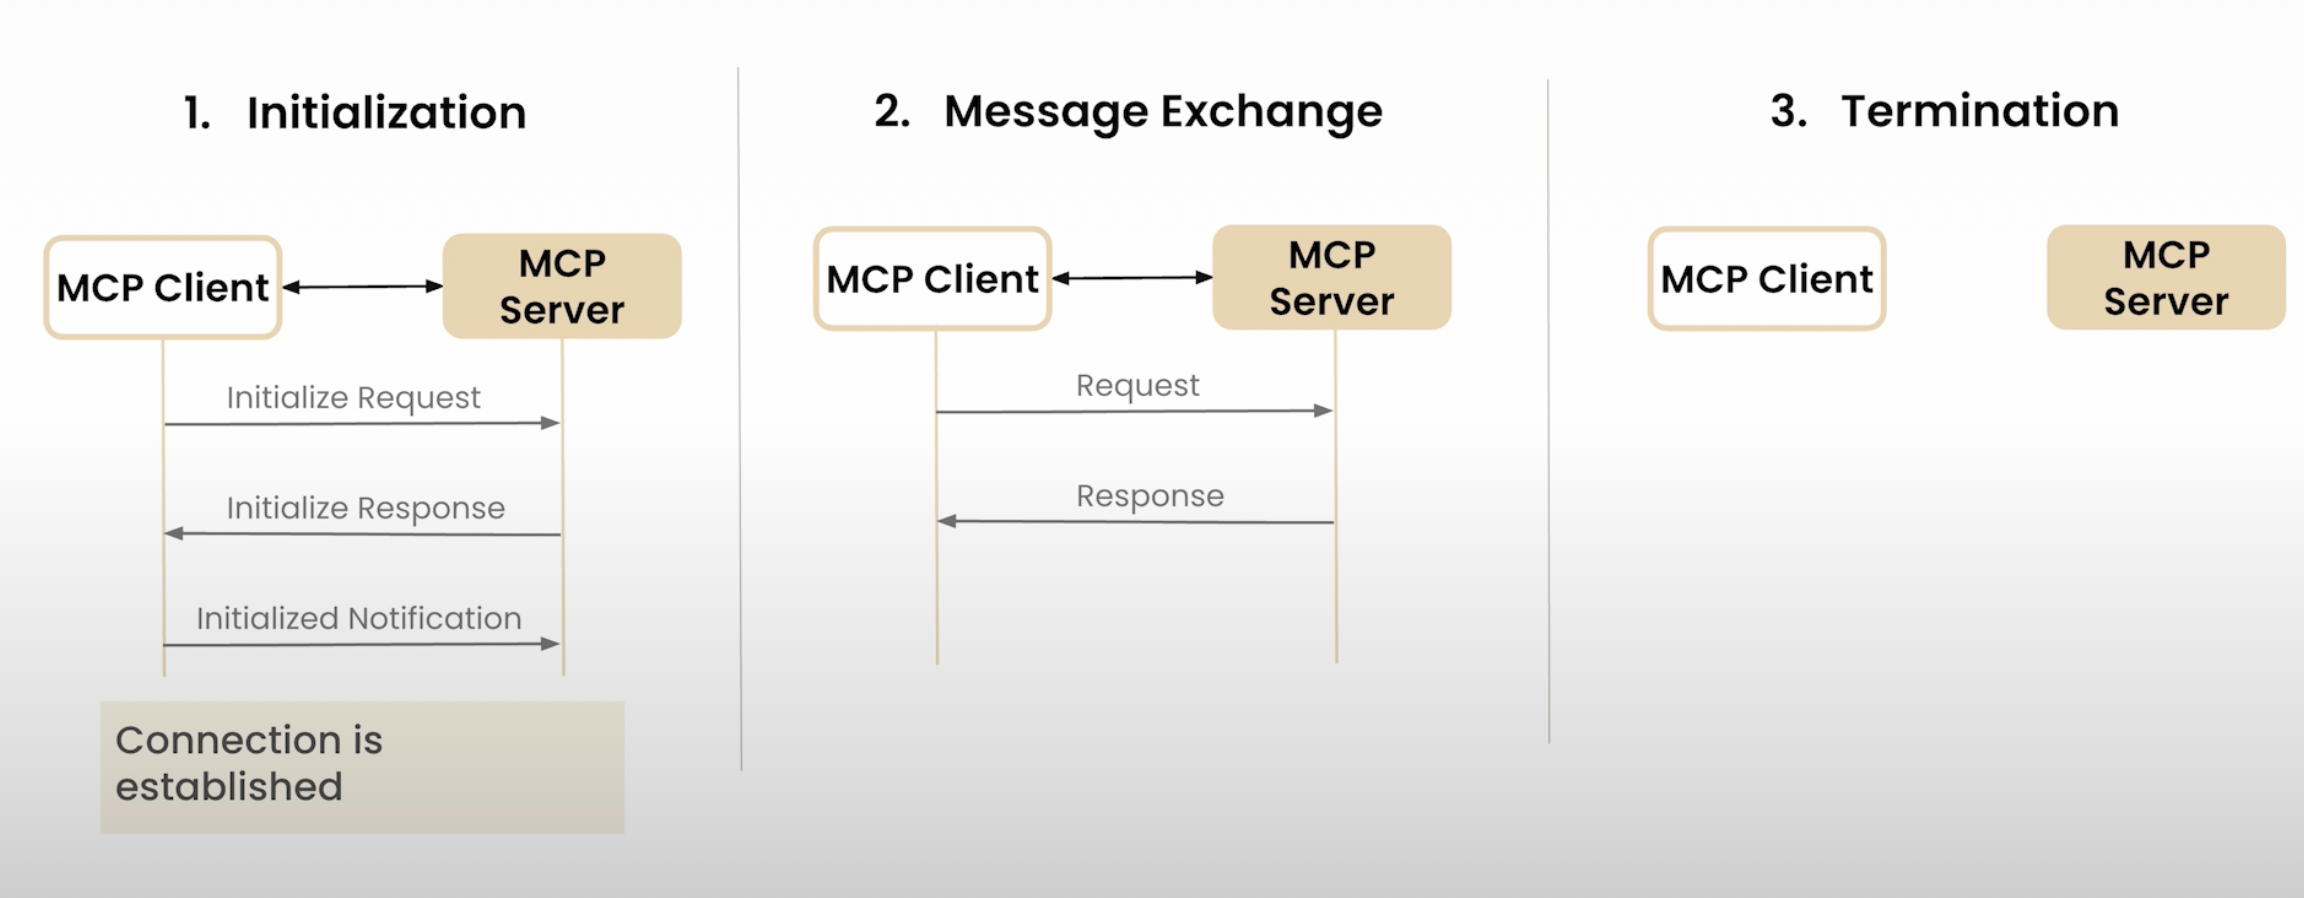

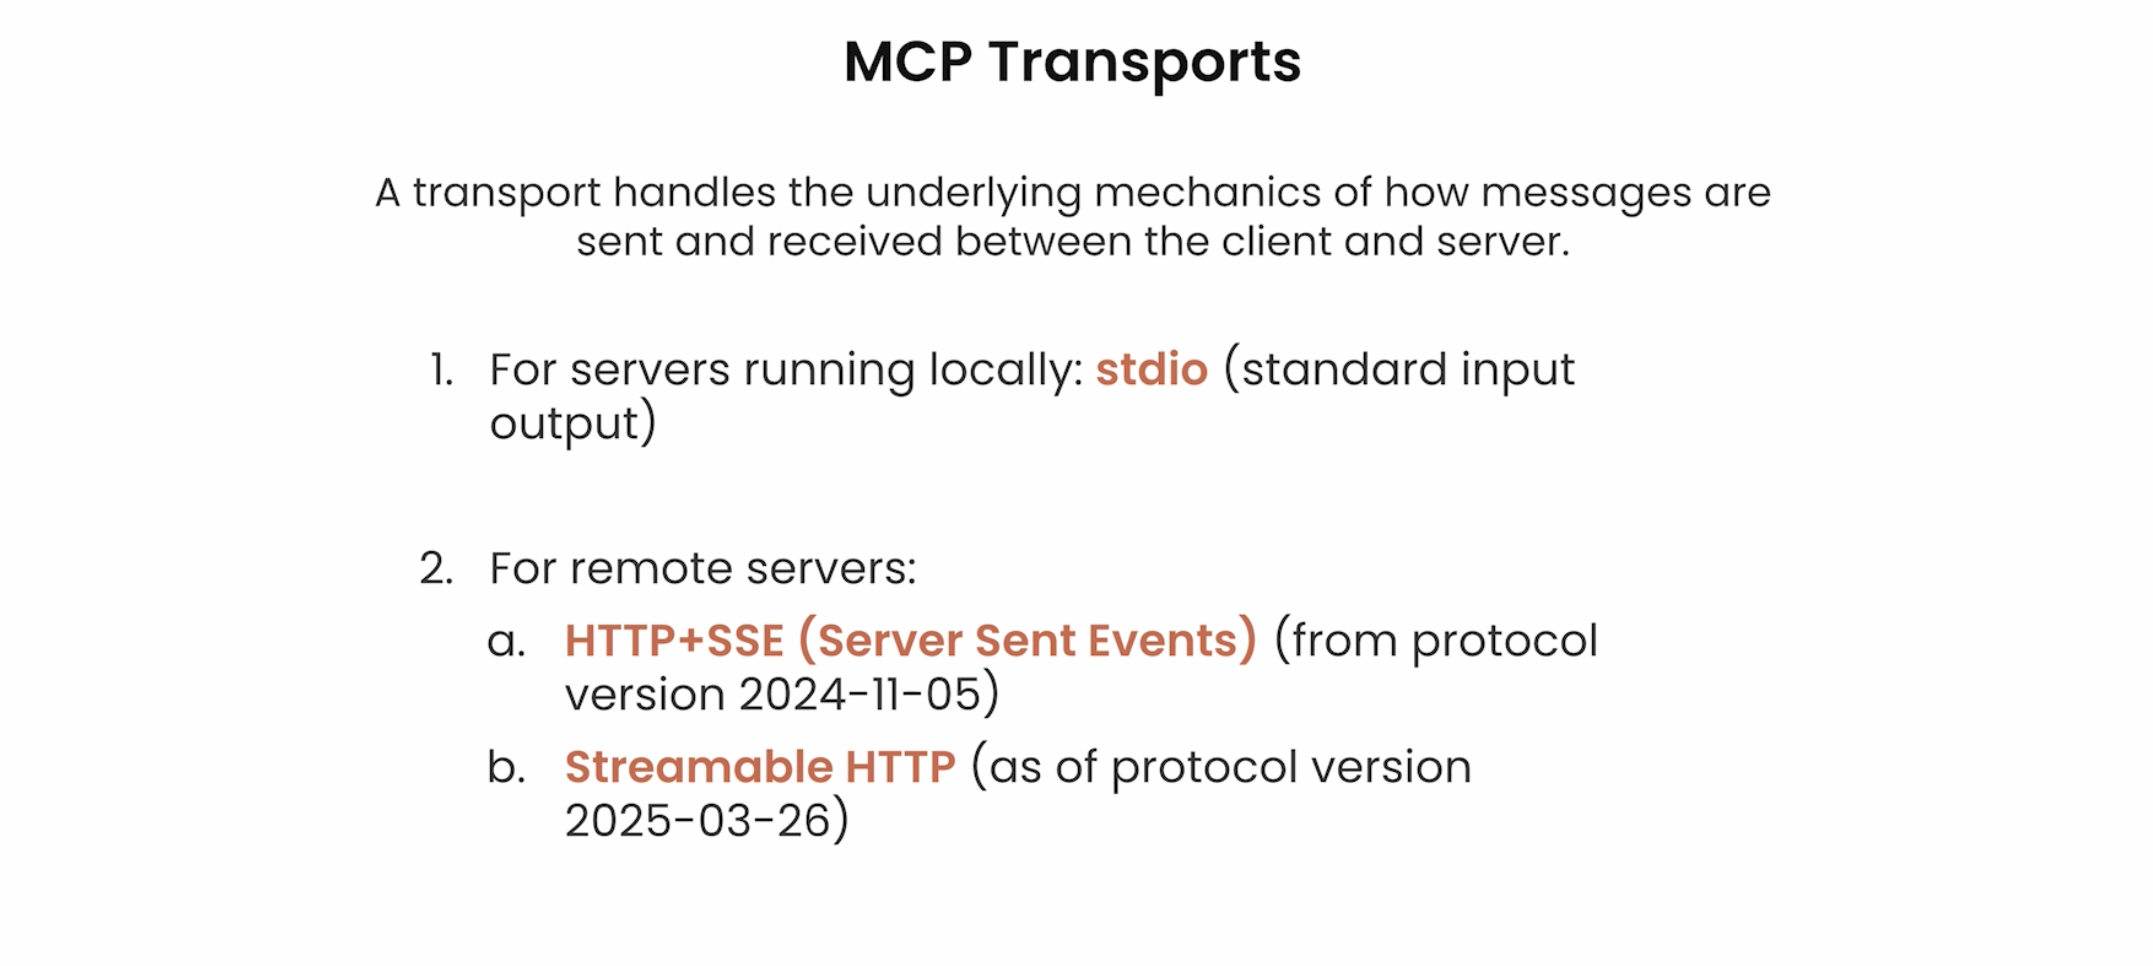

locally - fine standio
HTTP - allows stateful connection +  stateless

streamble -- not supported across yet - statefull
A stateful connection requires the server to remember information about the session, while a stateless connection treats each request as an independent transaction. Stateful connections are more complex and harder to scale because the server must store and manage session data, but they can be more efficient for certain tasks as they don't need to re-send all information with each request. Stateless connections are simpler, more scalable, and resilient to failure, but every request must include all necessary data. 

for standard  i/ 0
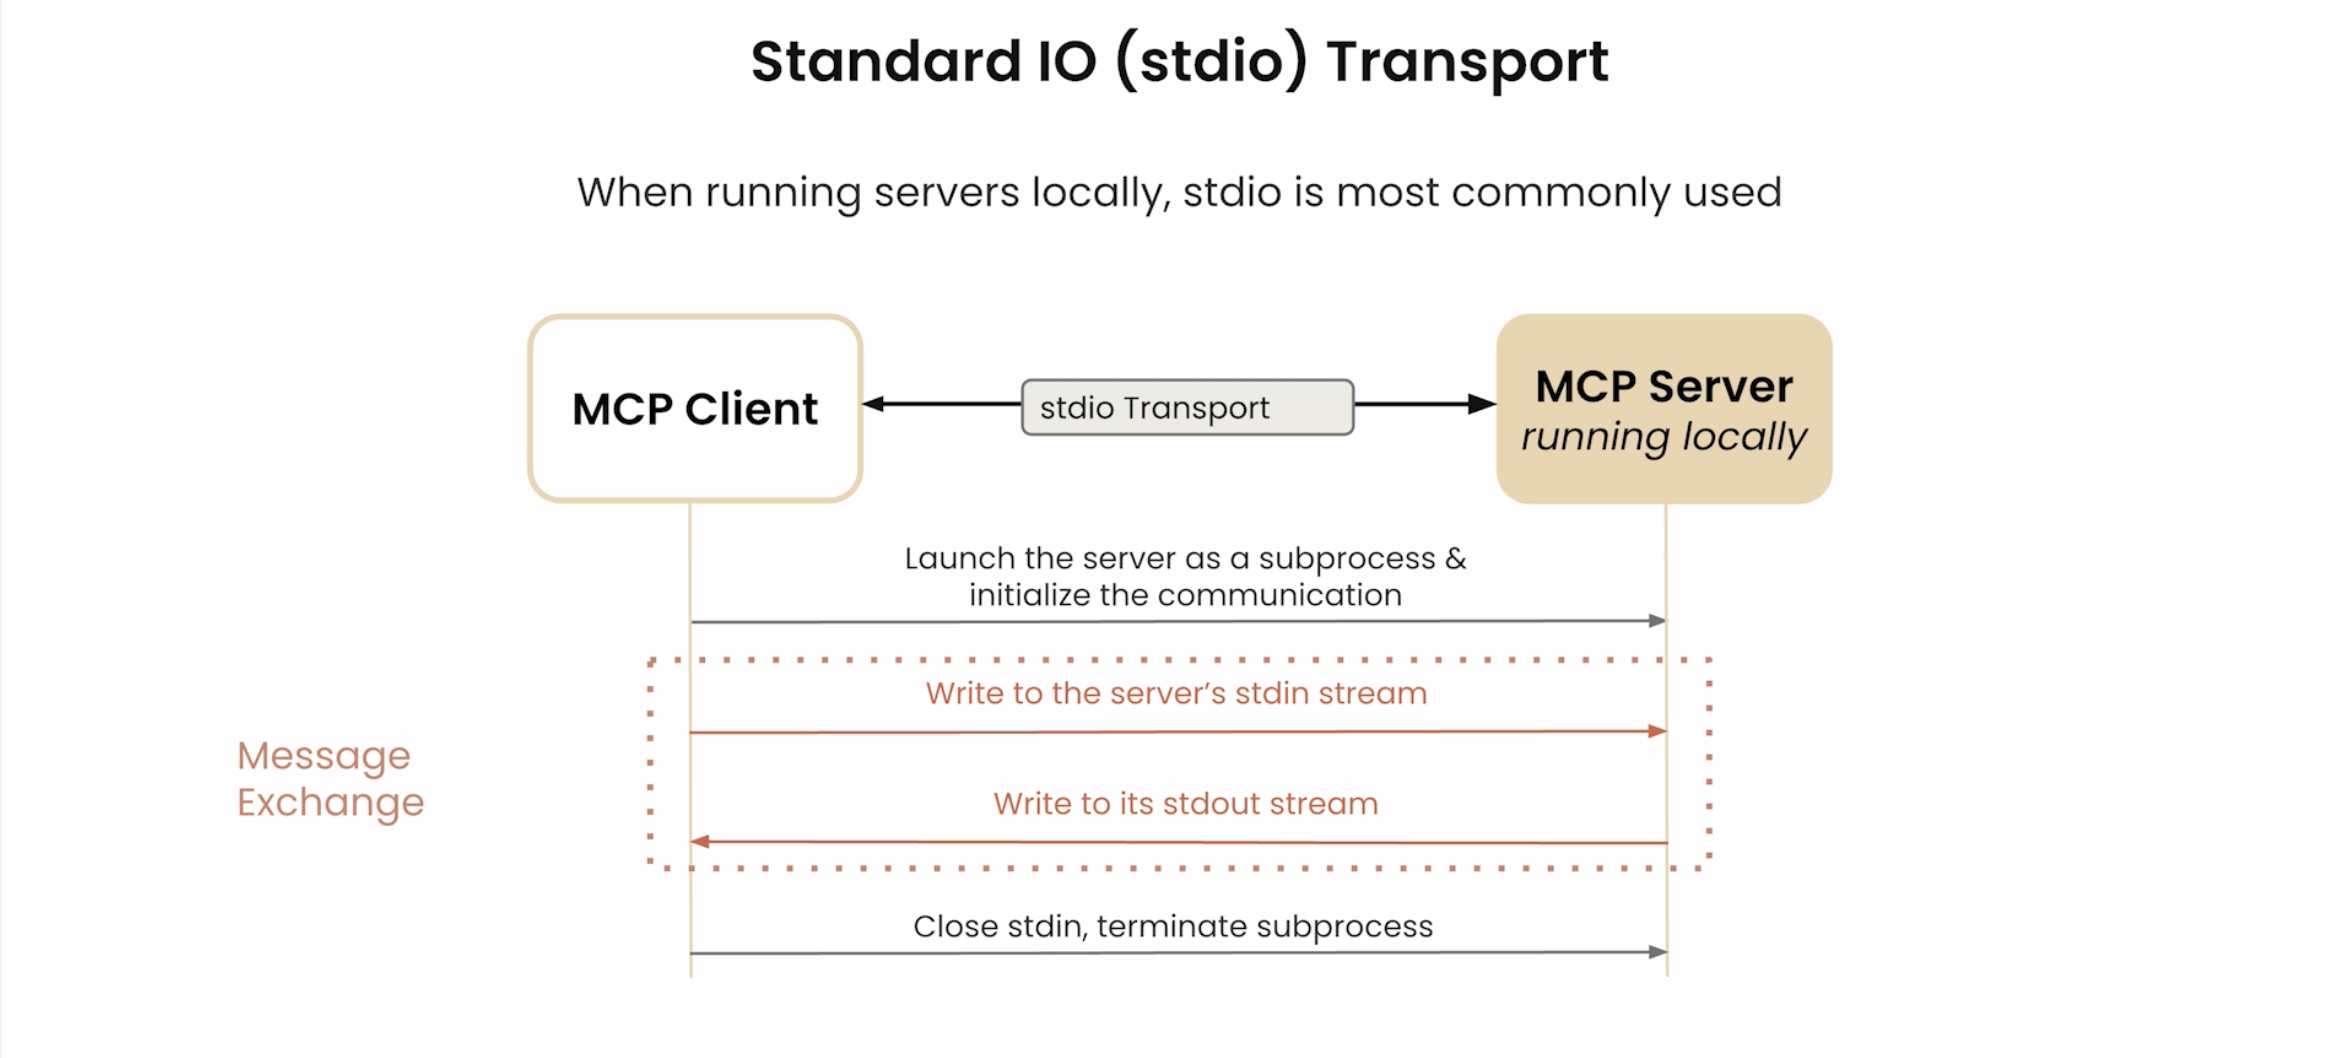

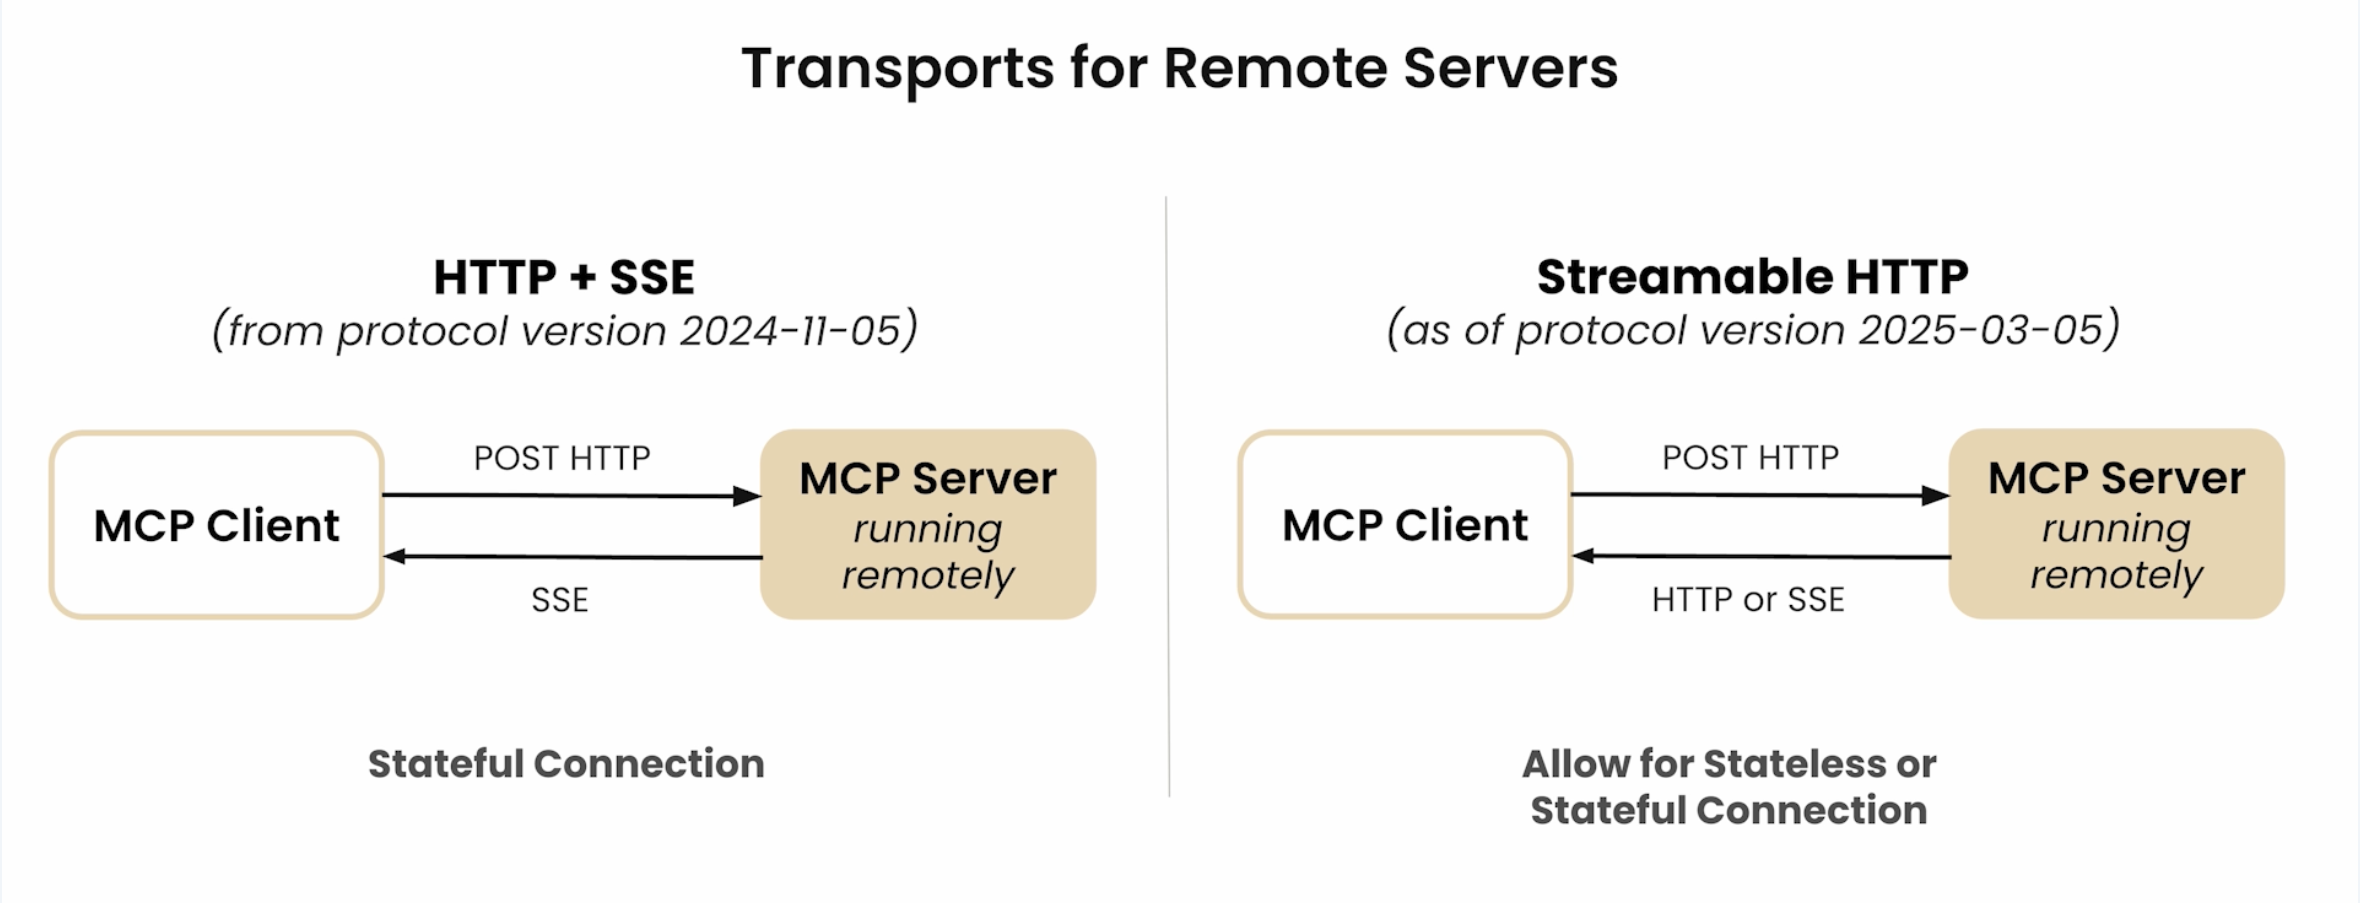

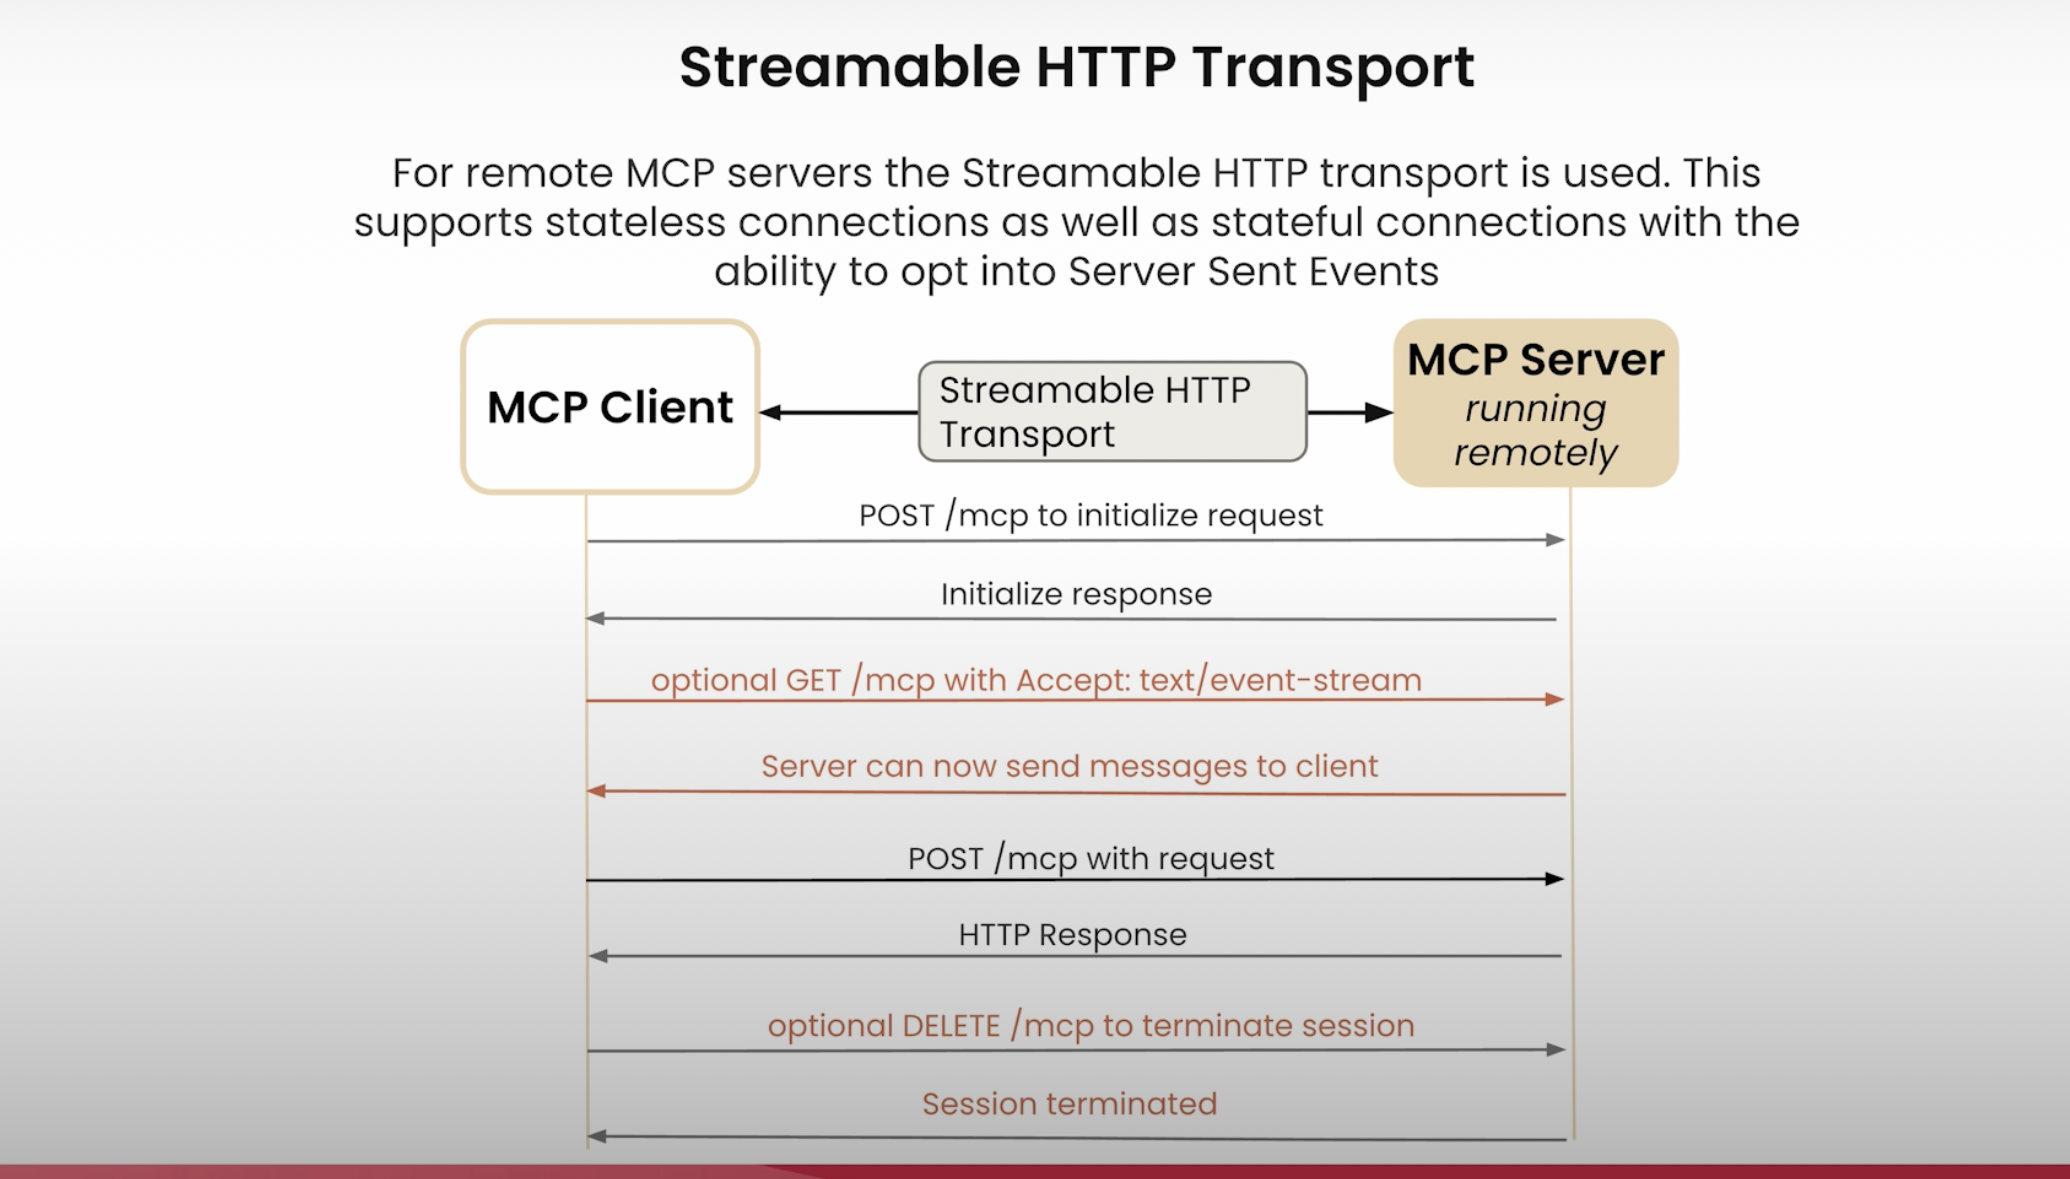

## Tool Functions

In [5]:
PAPER_DIR = "papers"

The first tool searches for relevant arXiv papers based on a topic and stores the papers' info in a JSON file (title, authors, summary, paper url and the publication date). The JSON files are organized by topics in the `papers` directory. The tool does not download the papers.  

In [8]:
def search_papers(topic: str, max_results: int = 5) -> List[str]:
    """
    Search for papers on arXiv based on a topic and store their information.
    
    Args:
        topic: The topic to search for
        max_results: Maximum number of results to retrieve (default: 5)
        
    Returns:
        List of paper IDs found in the search
    """
    
    # Use arxiv to find the papers 
    client = arxiv.Client() # many papers

    # Search for the most relevant articles matching the queried topic
    search = arxiv.Search(
        query = topic,
        max_results = max_results,
        sort_by = arxiv.SortCriterion.Relevance
    )
    
    papers = client.results(search) # pass that to client to get many papers
    
    # Create directory for this topic
    path = os.path.join(PAPER_DIR, topic.lower().replace(" ", "_"))
    os.makedirs(path, exist_ok=True)
    
    file_path = os.path.join(path, "papers_info.json")

    # Try to load existing papers info
    try:
        with open(file_path, "r") as json_file:
            papers_info = json.load(json_file)
    except (FileNotFoundError, json.JSONDecodeError):
        papers_info = {}

    # Process each paper and add to papers_info  
    paper_ids = []
    for paper in papers:
        paper_ids.append(paper.get_short_id())
        paper_info = {
            'title': paper.title,
            'authors': [author.name for author in paper.authors],
            'summary': paper.summary,
            'pdf_url': paper.pdf_url,
            'published': str(paper.published.date())
        }
        papers_info[paper.get_short_id()] = paper_info
    
    # Save updated papers_info to json file
    with open(file_path, "w") as json_file:
        json.dump(papers_info, json_file, indent=2)
    
    print(f"Results are saved in: {file_path}")
    
    return paper_ids

In [9]:
search_papers("computers")

Results are saved in: papers/computers/papers_info.json


['1310.7911v2',
 'math/9711204v1',
 '2208.00733v1',
 '2504.07020v1',
 '2403.03925v1']

The second tool looks for information about a specific paper across all topic directories inside the `papers` directory.

In [10]:
def extract_info(paper_id: str) -> str:
    """
    Search for information about a specific paper across all topic directories.
    
    Args:
        paper_id: The ID of the paper to look for
        
    Returns:
        JSON string with paper information if found, error message if not found
    """
 
    for item in os.listdir(PAPER_DIR):
        item_path = os.path.join(PAPER_DIR, item)
        if os.path.isdir(item_path):
            file_path = os.path.join(item_path, "papers_info.json")
            if os.path.isfile(file_path):
                try:
                    with open(file_path, "r") as json_file:
                        papers_info = json.load(json_file)
                        if paper_id in papers_info:
                            return json.dumps(papers_info[paper_id], indent=2)
                except (FileNotFoundError, json.JSONDecodeError) as e:
                    print(f"Error reading {file_path}: {str(e)}")
                    continue
    
    return f"There's no saved information related to paper {paper_id}."

In [11]:
extract_info('1310.7911v2')

'{\n  "title": "Compact manifolds with computable boundaries",\n  "authors": [\n    "Zvonko Iljazovic"\n  ],\n  "summary": "We investigate conditions under which a co-computably enumerable closed set\\nin a computable metric space is computable and prove that in each locally\\ncomputable computable metric space each co-computably enumerable compact\\nmanifold with computable boundary is computable. In fact, we examine the notion\\nof a semi-computable compact set and we prove a more general result: in any\\ncomputable metric space each semi-computable compact manifold with computable\\nboundary is computable. In particular, each semi-computable compact\\n(boundaryless) manifold is computable.",\n  "pdf_url": "http://arxiv.org/pdf/1310.7911v2",\n  "published": "2013-10-29"\n}'

## Tool Schema

Here are the schema of each tool which you will provide to the LLM.

In [12]:
tools = [
    {
        "name": "search_papers",
        "description": "Search for papers on arXiv based on a topic and store their information.",
        "input_schema": {
            "type": "object",
            "properties": {
                "topic": {
                    "type": "string",
                    "description": "The topic to search for"
                }, 
                "max_results": {
                    "type": "integer",
                    "description": "Maximum number of results to retrieve",
                    "default": 5
                }
            },
            "required": ["topic"]
        }
    },
    {
        "name": "extract_info",
        "description": "Search for information about a specific paper across all topic directories.",
        "input_schema": {
            "type": "object",
            "properties": {
                "paper_id": {
                    "type": "string",
                    "description": "The ID of the paper to look for"
                }
            },
            "required": ["paper_id"]
        }
    }
]

## Tool Mapping

This code handles tool mapping and execution.

In [13]:
mapping_tool_function = {
    "search_papers": search_papers,
    "extract_info": extract_info
}

def execute_tool(tool_name, tool_args):
    
    result = mapping_tool_function[tool_name](**tool_args)

    if result is None:
        result = "The operation completed but didn't return any results."
        
    elif isinstance(result, list):
        result = ', '.join(result)
        
    elif isinstance(result, dict):
        # Convert dictionaries to formatted JSON strings
        result = json.dumps(result, indent=2)
    
    else:
        # For any other type, convert using str()
        result = str(result)
    return result

## Chatbot Code

The chatbot handles the user's queries one by one, but it does not persist memory across the queries.

In [14]:
load_dotenv() 
client = anthropic.Anthropic()

### Query Processing

In [15]:
def process_query(query):
    
    messages = [{'role': 'user', 'content': query}]
    
    response = client.messages.create(max_tokens = 2024,
                                  model = 'claude-3-7-sonnet-20250219', 
                                  tools = tools,
                                  messages = messages)
    
    process_query = True
    while process_query:
        assistant_content = []

        for content in response.content:
            if content.type == 'text':
                
                print(content.text)
                assistant_content.append(content)
                
                if len(response.content) == 1:
                    process_query = False
            
            elif content.type == 'tool_use':
                
                assistant_content.append(content)
                messages.append({'role': 'assistant', 'content': assistant_content})
                
                tool_id = content.id
                tool_args = content.input
                tool_name = content.name
                print(f"Calling tool {tool_name} with args {tool_args}")
                
                result = execute_tool(tool_name, tool_args)
                messages.append({"role": "user", 
                                  "content": [
                                      {
                                          "type": "tool_result",
                                          "tool_use_id": tool_id,
                                          "content": result
                                      }
                                  ]
                                })
                response = client.messages.create(max_tokens = 2024,
                                  model = 'claude-3-7-sonnet-20250219', 
                                  tools = tools,
                                  messages = messages) 
                
                if len(response.content) == 1 and response.content[0].type == "text":
                    print(response.content[0].text)
                    process_query = False

### Chat Loop

In [16]:
def chat_loop():
    print("Type your queries or 'quit' to exit.")
    while True:
        try:
            query = input("\nQuery: ").strip()
            if query.lower() == 'quit':
                break
    
            process_query(query)
            print("\n")
        except Exception as e:
            print(f"\nError: {str(e)}")

Feel free to interact with the chatbot. Here's an example query: 

- Search for 2 papers on "LLM interpretability"

To access the `papers` folder: 1) click on the `File` option on the top menu of the notebook and 2) click on `Open` and then 3) click on `L3`.

In [ ]:
chat_loop()

Type your queries or 'quit' to exit.

Error: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"

Error: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"


<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b> To Access the <code>requirements.txt</code> file or the <code>papers</code> folder: </b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em> and finally 3) click on <em>"L3"</em>.
</div>

In the next lessons, you will take out the tool definitions to wrap them in an MCP server. Then you will create an MCP client inside the chatbot to make the chatbot MCP compatible.  

## Resources

[Guide on how to implement tool use](https://docs.anthropic.com/en/docs/build-with-claude/tool-use/overview#how-to-implement-tool-use)

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">


<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

</div>